In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from scipy import optimize

In [21]:
dataset = pd.read_csv("sim_data.csv")

In [22]:
dataset.head()

,ascale_norm,ds_norm,phi2_norm,filter_norm,har_fwd,power_norm
0,0.103619,0.955615,0.905666,0.784303,0.104009,0.999987
1,0.263004,0.994288,0.323467,0.259375,0.166655,0.999986
2,0.422238,0.996815,0.080871,0.059738,0.254533,0.999984
3,0.524909,0.991526,0.611798,0.092605,0.440757,0.999977
4,0.289211,0.934883,0.705519,0.607515,0.273508,0.999975


In [23]:
unused = dataset.pop('power_norm')

In [24]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

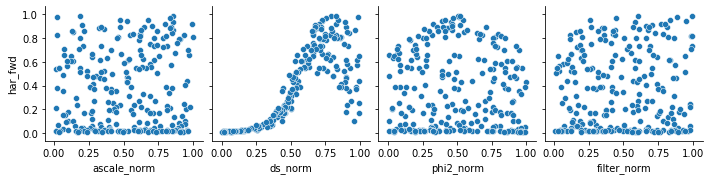

In [25]:
sns.pairplot(
    dataset,
    y_vars=["har_fwd"],
    x_vars=["ascale_norm","ds_norm","phi2_norm","filter_norm"],
)

In [26]:
train_labels = train_dataset.pop('har_fwd')
test_labels = test_dataset.pop('har_fwd')

In [27]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
        tf.keras.layers.Dense(64, activation=tf.nn.relu),
        tf.keras.layers.Dense(1)
    ])
    
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    
    model.compile(loss='mse',
                 optimizer=optimizer,
                 metrics=['mae', 'mse'])
    
    return model

In [28]:
model = build_model()

In [29]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128)               640       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 8,961
Trainable params: 8,961
Non-trainable params: 0
_________________________________________________________________


In [30]:
class PrintEpoch(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch,logs):
        if epoch == 0:
            print("Epoch:",epoch+1)        
        elif (epoch+1) % 1000 == 0:
            print("Epoch:",epoch+1)

In [31]:
EPOCHS = 4000

In [32]:
history = model.fit(
    train_dataset, train_labels,
    epochs=EPOCHS, validation_split=0.2, verbose=0,
    callbacks=[PrintEpoch()]
)

Epoch: 1
Epoch: 1000
Epoch: 2000
Epoch: 3000
Epoch: 4000


In [33]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error (har fwd)')
    plt.plot(np.array(hist['epoch']),np.array(hist['mae']),label="Train Error")
    plt.plot(np.array(hist['epoch']),np.array(hist['val_mae']),label="Val Error")  
    plt.legend()
        
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean square Error (har fwd)')
    plt.plot(np.array(hist['epoch']),np.array(hist['mse']),label="Train Error")
    plt.plot(np.array(hist['epoch']),np.array(hist['val_mse']),label="Val Error")      
    plt.legend()

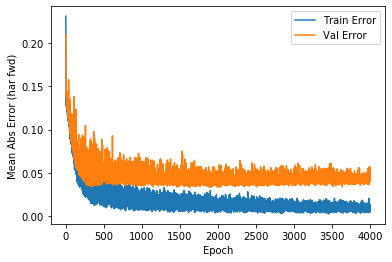

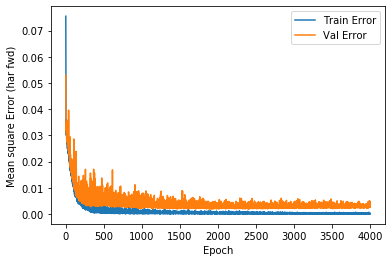

In [34]:
plot_history(history)

In [35]:
loss, mae, mse = model.evaluate(test_dataset, test_labels, verbose=0)
print(mae)

0.0362490750849247


In [36]:
def param_loss_fn(x):
    return 1-model.predict(np.expand_dims(np.array([x[0],x[1],x[2],x[3]]),axis=0))[0][0]

In [37]:
def param_error_fn(x):
    
    for ii in range(0, 4):
        if x[ii] < 0 or x[ii] > 1:
            return 1e9

    return param_loss_fn(x)**2

In [38]:
minimum = optimize.fmin(param_error_fn, x0=[.5,.5,.5,.5], xtol=1e-25, ftol=1e-25, disp=False)

In [39]:
print("ascale_norm =",minimum[0])
print("ds_norm =",minimum[1])
print("phi2_norm =",minimum[2])
print("filter_norm =",minimum[3])

ascale_norm = 0.9679022420584498
ds_norm = 0.7588612239142497
phi2_norm = 0.5276869342547482
filter_norm = 0.34131973631201884
